#### This notebook applies various ML algorithms to the pollen and weather data from Richmond, VA
We are looking at data from Richmond, Hampton, Danville, and Charlottesville grouped
by stations and merged on day from 1998 to 2018

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Read the CSV and Perform Basic Data Cleaning

In [2]:
### Data cleaning and merging was accomplished in the Preparing Richmond Data notebook, so straight read of data here.
df = pd.read_csv("pollen_wx_Region.csv")
df.head()

,Unnamed: 0,Tree,Mold,Grass,Ragweed,total-pol,LATITUDE_R,LONGITUDE_R,ELEVATION_R,AWND_R,...,LONGITUDE_H,ELEVATION_H,AWND_H,DAPR_H,MDPR_H,PRCP_H,TAVG_H,TMAX_H,TMIN_H,TOBS_H
0,1998-02-20,46.0,180.0,0.0,0.0,46.0,37.656523,-77.413727,59.866667,4.70,...,-76.28058,5.766667,5.145,NaN,NaN,0.020000,47.333333,51.333333,43.333333,NaN
1,1998-02-24,5.0,450.0,0.0,0.0,5.0,37.656523,-77.413727,59.866667,17.00,...,-76.28058,5.766667,16.105,NaN,NaN,0.016667,46.500000,53.666667,39.333333,NaN
2,1998-02-25,18.0,210.0,0.0,0.0,18.0,37.656523,-77.413727,59.866667,13.65,...,-76.28058,5.766667,13.755,NaN,NaN,0.000000,53.833333,62.000000,45.666667,NaN
3,1998-02-26,124.0,960.0,0.0,0.0,124.0,37.656523,-77.413727,59.866667,3.80,...,-76.28058,5.766667,6.150,NaN,NaN,0.000000,50.833333,60.333333,41.333333,NaN
4,1998-02-27,504.0,1260.0,0.0,0.0,504.0,37.656523,-77.413727,59.866667,4.25,...,-76.28058,5.766667,4.140,NaN,NaN,0.000000,52.166667,66.666667,37.666667,NaN


#### From the column definitions, 
We note that the parameters which are most likely associated with pollens have to do with the "growth" seasons
from March through September, when the atmosphere is warming and there is more rain. Therefore, we initially select 
Precipitation, Average Temperature, and average wind as the feature set used to predict Total Pollen, 
not including mold spores.

In [4]:
# Set features. This will also be used as your x values.
df["allergens"] = df['total-pol'] + df["Mold"]
# selected_features = df[['PRCP_R','TAVG_R', 'AWND_R', 'PRCP_C','TAVG_C', 'AWND_C', 
#                         'PRCP_D','TAVG_D', 'AWND_D','PRCP_H','TAVG_H', 'AWND_H',
#                         'allergens']].dropna()
selected_features = df[['PRCP_R','TAVG_R', 'PRCP_C','TAVG_C','PRCP_D','TAVG_D','PRCP_H','TAVG_H','allergens']].dropna()

In [5]:
selected_features.tail()

,PRCP_R,TAVG_R,PRCP_C,TAVG_C,PRCP_D,TAVG_D,PRCP_H,TAVG_H,allergens
3384,0.000000,41.666667,0.0425,40.875,0.00,45.5,0.0025,47.500,940.0
3385,0.673333,43.666667,0.0975,40.000,0.15,30.0,0.4650,48.625,990.0
3386,0.000000,41.500000,0.0000,41.875,0.00,40.5,0.0000,49.125,1530.0
3387,0.000000,42.833333,0.0125,38.875,0.00,11.0,0.0000,49.375,1020.0
3388,0.006667,52.000000,0.0250,44.500,0.00,38.5,0.0000,55.000,1215.0


In [6]:
selected_features = selected_features[selected_features["allergens"] > 0]

In [7]:
print(selected_features["allergens"].min())

2.0


#### Create a Train Test Split
Note there are 1060 records in the data set from the cell above.
Use `total-pol` for the y ("target") values

In [9]:
print(f"The length of combined regional data set is: {len(selected_features)}" )

The length of combined regional data set is: 3202


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [11]:
#assign x and y values
X = selected_features.drop("allergens", axis=1)

feature_names=X.columns

y = selected_features["allergens"]

print(y)

#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63)

0        226.0
1        455.0
2        228.0
3       1084.0
4       1764.0
         ...  
3384     940.0
3385     990.0
3386    1530.0
3387    1020.0
3388    1215.0
Name: allergens, Length: 3202, dtype: float64


In [12]:
X_train.tail()

,PRCP_R,TAVG_R,PRCP_C,TAVG_C,PRCP_D,TAVG_D,PRCP_H,TAVG_H
2477,0.00,52.625000,0.000,53.500,0.000,55.666667,0.1375,57.250000
1280,2.51,67.000000,3.125,66.500,0.895,65.166667,3.8625,71.875000
139,0.00,61.833333,0.000,62.250,0.530,66.000000,0.0000,64.166667
3374,0.00,52.833333,0.000,50.875,0.000,54.000000,0.0000,54.875000
1102,0.00,43.625000,0.000,43.000,0.000,43.000000,0.0000,46.625000


In [13]:
y_train.tail()

2477    2460.0
1280    5931.0
139     5799.0
3374    3540.0
1102    1440.0
Name: allergens, dtype: float64

### Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [14]:
### Multiple regression model since there are only 3 features

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
### END SOLUTION

 # Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")


Training Score: 0.38260643370480796
Testing Score: 0.3516783775513854


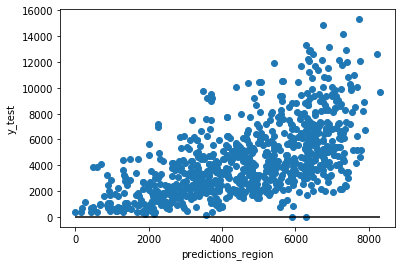

In [15]:
predictions = model.predict(X_test)
predictions = np.array([0 if p < 0 else p for p in predictions])
# Plot Residuals
plt.xlabel('predictions_region')
plt.ylabel('y_test')
plt.scatter(predictions, y_test)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 5153732.546301785
R-squared (R2 ): 0.3517249619599787


In [ ]:
### Look at decision tree - regression as an alternative

In [17]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


In [ ]:
## KEEP THIS EXAMPLE IN THE NOTEBOOK TO REMIND ME HOW TO USE
# # Import the necessary modules and libraries

# # Create a random dataset
# rng = np.random.RandomState(1)
# X = np.sort(5 * rng.rand(80, 1), axis=0)
# y = np.sin(X).ravel()
# y[::5] += 3 * (0.5 - rng.rand(16))

# # Fit regression model
# regr_1 = DecisionTreeRegressor(max_depth=2)
# regr_2 = DecisionTreeRegressor(max_depth=5)
# regr_1.fit(X, y)
# regr_2.fit(X, y)

# # Predict
# X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
# y_1 = regr_1.predict(X_test)
# y_2 = regr_2.predict(X_test)

# # Plot the results
# plt.figure()
# plt.scatter(X, y, s=20, edgecolor="black",
#             c="darkorange", label="data")
# plt.plot(X_test, y_1, color="cornflowerblue",
#          label="max_depth=2", linewidth=2)
# plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
# plt.xlabel("data")
# plt.ylabel("target")
# plt.title("Decision Tree Regression")
# plt.legend()
# plt.show()

In [ ]:
regr_1.score(X,y)

In [ ]:
print(X_train.shape)
print(y_train.shape)


In [37]:
# from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 63, max_depth=12)

regressor.fit(X_train, y_train)

# Predicting a new result with the Decision Tree Regression

Y_Pred = regressor.predict(X_test)

regressor.score(X_test, y_test)

# # # Visualising the Decision Tree Regression results in higher resolution and smoother curve
# X_Grid = np.arange(min(X_train), max(X_train), 0.01)
# X_Grid = X_Grid.reshape((len(X_Grid), 1))
# plt.scatter(X_train,y_train, color = 'red')
# plt.plot(X_test, regressor.predict(X_test), color = 'blue')
# plt.title('Decision Tree Regression Results')
# plt.xlabel('Weather')
# plt.ylabel('Allergens')
# plt.show()

-0.08422471274139864

In [38]:
# Score the prediction with mse and r2
mse = mean_squared_error(y_test, Y_Pred)
r2 = r2_score(y_test, Y_Pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 8619496.1423381
R-squared (R2 ): -0.08422471274139864


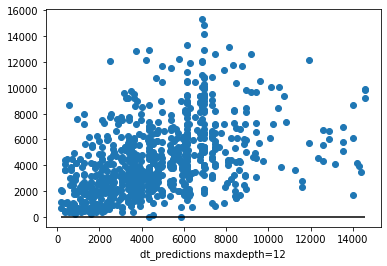

In [40]:
predictions = regressor.predict(X_test)
# predictions = np.array([0 if p < 0 else p for p in predictions])
# Plot Residuals
plt.xlabel("dt_predictions maxdepth=12")
plt.scatter(predictions, y_test)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [41]:
training_score = regressor.score(X_train, y_train)
testing_score = regressor.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.7865318858476307
Testing Score: -0.08422471274139864


In [42]:
# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 8619496.1423381
R-squared (R2 ): -0.08422471274139864


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
# x = np.arange(5)
# y = 3 - 2 * x + x ** 2 - x ** 3
# model = model.fit(x[:, np.newaxis], y)
model = model.fit(X_train, y_train)
model.named_steps['linear'].coef_

In [ ]:
predictions = model.predict(X_test)
# Plot Residuals
model.score(X_test, y_test)

In [ ]:
# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

In [ ]:
predictions = model.predict(X_test)
predictions = np.array([0 if p < 0 else p for p in predictions])
# Plot Residuals
plt.scatter(predictions, y_test)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [64]:
from sklearn.neighbors import RadiusNeighborsRegressor
neigh = RadiusNeighborsRegressor(radius=15)

neigh.fit(X_train, y_train)

print(neigh.predict(X_test))

[6634.79386845 6690.78236686 4899.30975309 2657.66769231 7319.66403162
 3918.20426743 2340.24836601 1212.03361345 5556.75928489 6118.31017699
 7151.64447236 4394.9802969  6709.56180723 3631.82043551 5588.03260369
 3079.92244165 6781.03976064 6587.28223897 6109.63249243 6525.7258956
 6884.79893455 3348.86755853 4666.7052161  2453.44570136 5101.001125
 6614.83619362 4520.5496361  2368.04669261 2844.25629921 6296.48436874
 6496.19180328 5252.86122209 4243.11280576 3767.40449827 6176.79522863
 3242.03567753 6295.31084577 6735.62212042 5183.75941677 1979.4151436
 3423.48917609 6419.58450561 6635.15463576 6758.35774112 4376.18609929
 5287.84832936 6200.64901758 6283.06115538 5915.59338759 4295.95567568
 5196.72694118 4807.37625628 6320.82213115 3749.43262195 3735.50842607
 7595.72159091 6349.26387226 5417.0716092  4541.88529412 4594.49259777
 2251.05324074 2652.93144016 4137.72744828 3980.82447257 5437.95881643
 7102.73690476 6498.90121212 4226.7925     4261.17159309 4252.0111869
 3705.24672

In [65]:
# Score the prediction with mse and r2
predictions = neigh.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 5226997.472351271
R-squared (R2 ): 0.3425091514197496


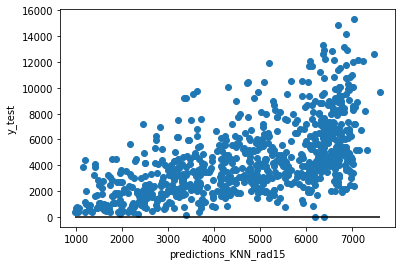

In [66]:
# predictions = model.predict(X_test)
predictions = np.array([0 if p < 0 else p for p in predictions])
# Plot Residuals
plt.xlabel("predictions_KNN_rad15")
plt.ylabel("y_test")
plt.scatter(predictions, y_test)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

# Save the Model

In [67]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = 'pollen_KNN15_Colton.sav'
joblib.dump(neigh, filename)

['pollen_KNN15_Colton.sav']